In [1]:
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle as rect
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", 
    message="ModflowDis.sr is deprecated. use Modflow.sr")
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

import flopy
import pyemu

## Model background

The inverse problem has 500 paramters - all pilot point multipliers for hk

There are no omitted parameters - potential omitted paramters are bc parameters (conductance, flux)

(a list of potential parameters: hydraulic conductivity of each active model cell, calibration and forecast period recharge multipliers, storage and specific yield, calibration and forecast well flux for each of the six wells, and river bed conductance for each 40 cells with river-type boundary conditions).

The inverse problem has 469 head obseravtions.

The forecasts of interest include obs named rwp003_93.08

The forecasts are included in the Jacobian matrix as zero-weight observations. The model files, pest control file and previously-calculated jacobian matrix are in the `all_layers` folder


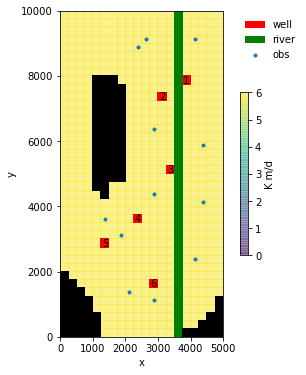

In [2]:
# this is from the original notebook for the freyberg model: need to replicate this for MRGB or RSJ models

# load the model
model_ws = os.path.join("Freyberg","extra_crispy")
ml = flopy.modflow.Modflow.load("freyberg.nam",model_ws=model_ws)

# plot some model attributes
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111,aspect="equal")
ml.upw.hk.plot(axes=[ax],colorbar="K m/d",alpha=0.3)
ml.wel.stress_period_data.plot(axes=[ax])
ml.riv.stress_period_data.plot(axes=[ax])

# plot obs locations
obs = pd.read_csv(os.path.join("freyberg","misc","obs_rowcol.dat"),
                  delim_whitespace=True)
obs_x = [ml.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [ml.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.',label="obs")

#plot names on the pumping well locations
wel_data = ml.wel.stress_period_data[0]
wel_x = ml.sr.xcentergrid[wel_data["i"],wel_data["j"]]
wel_y = ml.sr.ycentergrid[wel_data["i"],wel_data["j"]]
for i,(x,y) in enumerate(zip(wel_x,wel_y)):
    ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

ax.set_ylabel("y")
ax.set_xlabel("x")

ax.add_patch(rect((0,0),0,0,label="well",ec="none",fc="r"))
ax.add_patch(rect((0,0),0,0,label="river",ec="none",fc="g"))

ax.legend(bbox_to_anchor=(1.5,1.0),frameon=False)
plt.savefig("domain.pdf")

In [2]:
# load the MRGB model
model_ws = 'all_layers'
ml = flopy.modflow.Modflow.load("mrgb.nam",model_ws=model_ws)

/Users/rishijumani/anaconda2/lib/python2.7/site-packages/numpy/core/records.py:507: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.13 because this will return a view instead of a copy -- see release notes for details.
  return obj.view(dtype=(self.dtype.type, obj.dtype))


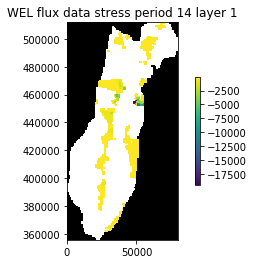

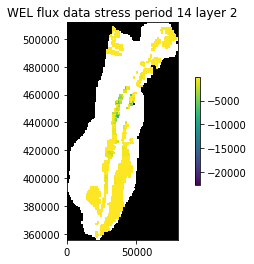

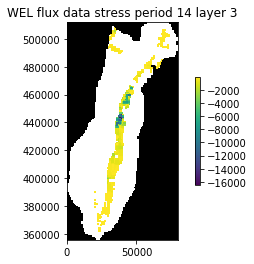

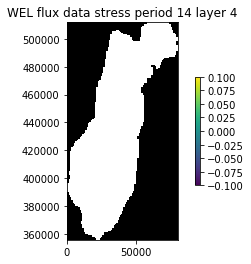

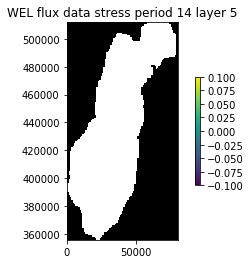

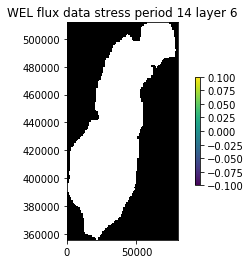

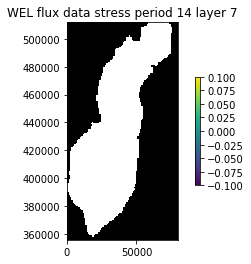

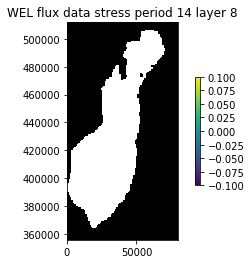

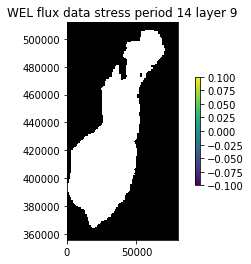

In [3]:
ml.wel.plot(kper = 13, key='flux')
#ml.wel.stress_period_data.plot()
#ml.wel.stress_period_data[1].plot(axes=[ax])

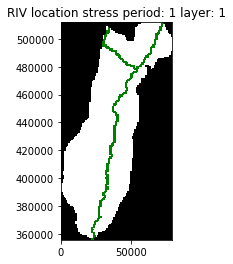

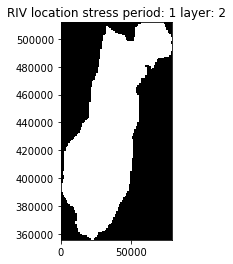

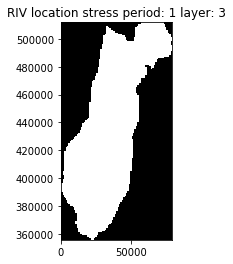

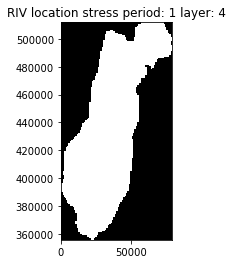

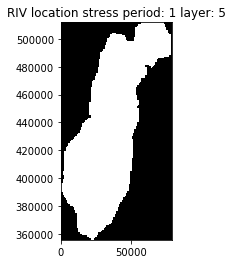

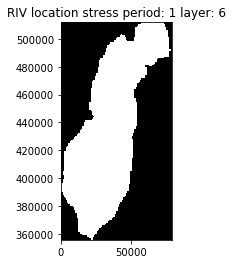

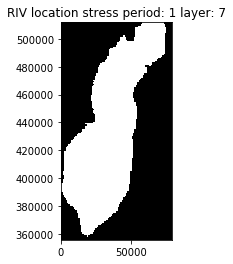

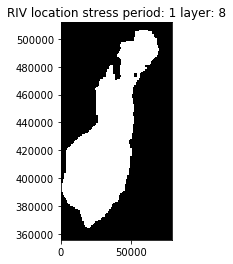

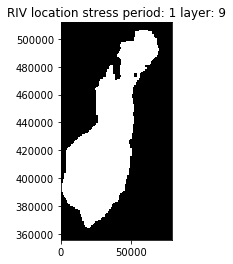

In [28]:
riv = ml.riv.stress_period_data

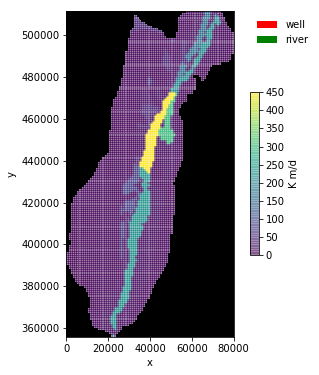

In [58]:
# plot some model attributes
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111,aspect="equal")
ml.lpf.hk[0].plot(axes=[ax],colorbar="K m/d",alpha=0.3)
#ml.wel.stress_period_data.plot(axes=[ax])
#ml.riv.stress_period_data.plot(axes=[ax])


# plot obs locations
# obs = pd.read_csv(os.path.join("freyberg","misc","obs_rowcol.dat"),
#                   delim_whitespace=True)
# obs_x = [ml.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
# obs_y = [ml.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
# ax.scatter(obs_x,obs_y,marker='.',label="obs")


#plot names on the pumping well locations
# wel_data = ml.wel.stress_period_data[0]
# wel_x = ml.sr.xcentergrid[wel_data["i"],wel_data["j"]]
# wel_y = ml.sr.ycentergrid[wel_data["i"],wel_data["j"]]
# for i,(x,y) in enumerate(zip(wel_x,wel_y)):
#     ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

ax.set_ylabel("y")
ax.set_xlabel("x")

ax.add_patch(rect((0,0),0,0,label="well",ec="none",fc="r"))
ax.add_patch(rect((0,0),0,0,label="river",ec="none",fc="g"))

ax.legend(bbox_to_anchor=(1.5,1.0),frameon=False)
plt.savefig("domain.pdf")

## Error Variance

First create a linear_analysis object.  pyemu uses the `ErrVar` derived type, which replicates the behavior of the `PREDVAR` suite of PEST as well as `ident_par` utility.  We pass it the name of the jacobian matrix file.  Since we don't pass an explicit argument for `parcov` or `obscov`, `pyemu` attempts to build them from the parameter bounds and observation weights in a pest control file (.pst) with the same base case name as the jacobian.  Since we are interested in forecast uncertainty as well as parameter uncertainty, we also pass the names of the forecast sensitivity vectors we are interested in, which are stored in the jacobian as well.  Note that the `forecasts` argument can be a mixed list of observation names, other jacobian files or PEST-compatible ASCII matrix files. You can pass a filename to the `verbose` argument to write log file.

Since most groundwater model history-matching analyses focus on adjusting hetergeneous hydraulic properties and not boundary condition elements, you can identify the well flux (or conductance) and recharge parameters as `omitted` in the error variance analysis.  You can conceptually think of this action as excluding these parameters from the history-matching process. Later we will explicitly calculate the penalty for not adjusting these parameters.

In [4]:
# get the list of forecast names from the pest++ argument
# in the pest control file
jco = os.path.join("all_layers","mrgb.jcb")
pst = pyemu.Pst(jco.replace("jcb","pst"))

In [ ]:
omitted = [pname for pname in pst.par_names if \
           pname.startswith("wf") or pname.startswith("rch")]

In [6]:
forecasts = pst.pestpp_options["forecasts"].split(',')
la = pyemu.ErrVar(jco=jco,verbose="errvar_mrgb.log")
print("observations, parameters found in jacobian:",la.jco.shape)

observations, parameters found in jacobian: (469, 500)


# Parameter identifiability
The `errvar` dervied type exposes a method to get a `pandas` dataframe of parameter identifiability information. Parameter identifiability is expressed as $d_i = \Sigma(\mathbf{V}_{1i})^2$, where $d_i$ is the parameter identifiability, which ranges from 0 (not identified by the data) to 1 (full identified by the data), and $\mathbf{V}_1$ are the right singular vectors corresonding to non-(numerically) zero singular values.  First let's look at the singular spectrum of $\mathbf{Q}^{\frac{1}{2}}\mathbf{J}$, where $\mathbf{Q}$ is the cofactor matrix and $\mathbf{J}$ is the jacobian:

In [7]:
s = la.qhalfx.s

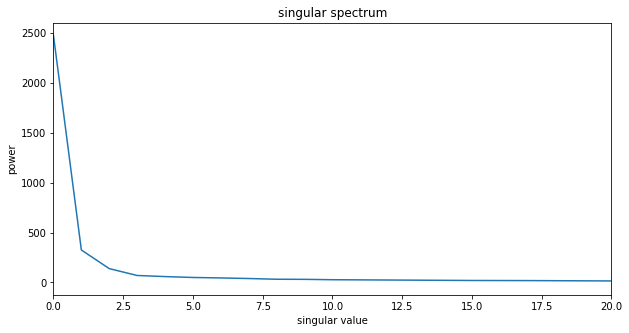

In [8]:
import pylab as plt
figure = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(s.x)
ax.set_title("singular spectrum")
ax.set_ylabel("power")
ax.set_xlabel("singular value")
ax.set_xlim(0,20)
plt.show()

We see that the singluar spectrum decays rapidly (not uncommon) and that we can really only support about 10 (5?) right singular vectors even though we have 500+ parameters in the inverse problem.  

Let's get the identifiability dataframe at 10 singular vectors:

In [17]:
# the method is passed the number of singular vectors to include in V_1
ident_df = la.get_identifiability_dataframe(10) 
ident_df.sort_values(by="ident",ascending=False).iloc[0:10]

,right_sing_vec_1,right_sing_vec_2,right_sing_vec_3,right_sing_vec_4,right_sing_vec_5,right_sing_vec_6,right_sing_vec_7,right_sing_vec_8,right_sing_vec_9,right_sing_vec_10,ident
hk300,6.660259e-04,4.460479e-01,2.697149e-01,0.027837,0.016416,0.039687,0.013523,0.002238,0.053961,0.001900,0.871992
hk403,2.592613e-05,2.039820e-02,2.079603e-01,0.075182,0.072745,0.242779,0.062154,0.002982,0.102392,0.001380,0.787998
hk200,5.239979e-04,3.304169e-01,2.093026e-01,0.030995,0.008554,0.026324,0.030677,0.000271,0.072188,0.004870,0.714122
hk530,4.276453e-09,1.680391e-04,2.837264e-04,0.066706,0.299498,0.097016,0.059367,0.003355,0.001717,0.005709,0.533819
hk503,2.201455e-02,7.601919e-03,1.389448e-02,0.199629,0.106595,0.039590,0.074609,0.019035,0.028707,0.000473,0.512148
hk100,1.438255e-04,8.912306e-02,2.154466e-01,0.013021,0.007056,0.002357,0.014950,0.001428,0.103122,0.006404,0.453052
hk611,2.268761e-02,5.065285e-02,6.952049e-05,0.019001,0.015341,0.000093,0.048390,0.003543,0.204325,0.022791,0.386892
hk258,1.167238e-09,3.742062e-08,4.328008e-08,0.000141,0.000800,0.000311,0.004651,0.153711,0.004288,0.069445,0.233347
hk305,3.187566e-05,8.763587e-03,8.661396e-03,0.008076,0.002056,0.022851,0.062932,0.004643,0.048669,0.004343,0.171027
hk512,2.001154e-02,1.731419e-05,4.229613e-05,0.034267,0.006353,0.035535,0.011426,0.002519,0.001207,0.018597,0.129973


Plot the indentifiability:

Text(0,0.5,u'identifiability')

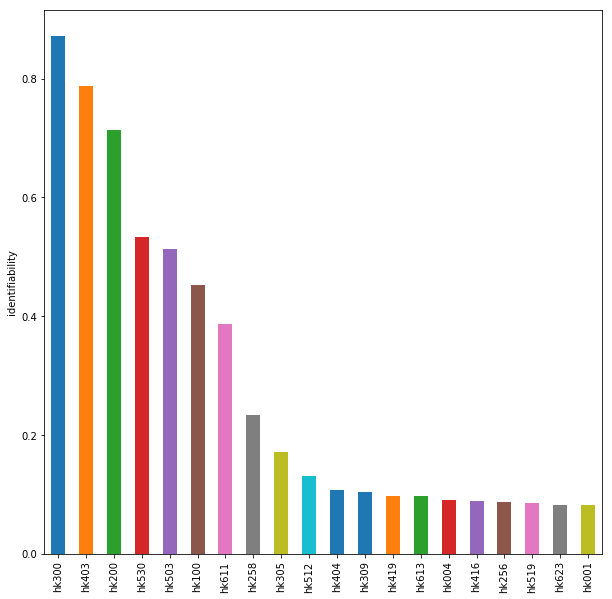

In [18]:
ax = ident_df.sort_values(by="ident",ascending=False).iloc[0:20].\
     loc[:,"ident"].plot(kind="bar",figsize=(10,10))
ax.set_ylabel("identifiability")

# Forecast error variance 

Next explore the error variance of the forecasts we are interested in.  We will use an extended version of the forecast error variance equation:   

$\sigma_{s - \hat{s}}^2 = \underbrace{\textbf{y}_i^T({\bf{I}} - {\textbf{R}})\boldsymbol{\Sigma}_{{\boldsymbol{\theta}}_i}({\textbf{I}} - {\textbf{R}})^T\textbf{y}_i}_{1} + \underbrace{{\textbf{y}}_i^T{\bf{G}}\boldsymbol{\Sigma}_{\mathbf{\epsilon}}{\textbf{G}}^T{\textbf{y}}_i}_{2} + \underbrace{{\bf{p}}\boldsymbol{\Sigma}_{{\boldsymbol{\theta}}_o}{\bf{p}}^T}_{3}$

Where term 1 is the null-space contribution, term 2 is the solution space contribution and term 3 is the model error term (the penalty for not adjusting uncertain parameters) - the well flux and recharge parameters that can be marked as omitted.  **The consequences of that action can now be explicitly evaluated.**  See Moore and Doherty (2005) and White and other (2014) for more explanation of these terms.  Note that if you don't have any `omitted_parameters`, the only terms 1 and 2 contribute to error variance

First we need to create a list (or numpy ndarray) of the singular values we want to test.  Since we have 10 data, we only need to test up to $11$ singular values because that is where the action is:

In [19]:
sing_vals = np.arange(11)

The `ErrVar` derived type exposes a method to get a multi-index pandas dataframe with each of the terms of the error variance equation:

In [20]:
errvar_df = la.get_errvar_dataframe(sing_vals)
errvar_df.iloc[0:10]

,first,second,third
,rwp003_93.08,rwp003_93.08,rwp003_93.08
0,1.957639,0.000000e+00,0.0
1,1.912272,2.956528e-08,0.0
2,1.898983,5.313758e-07,0.0
3,1.898983,5.314293e-07,0.0
4,1.883603,1.316676e-05,0.0
5,1.531718,4.196600e-04,0.0
6,1.207113,9.422384e-04,0.0
7,1.205600,9.451892e-04,0.0
8,0.935492,1.641789e-03,0.0


In [13]:
errvar_df[["first"]].to_latex("sw_gw_0.tex")

plot the error variance components for each forecast:

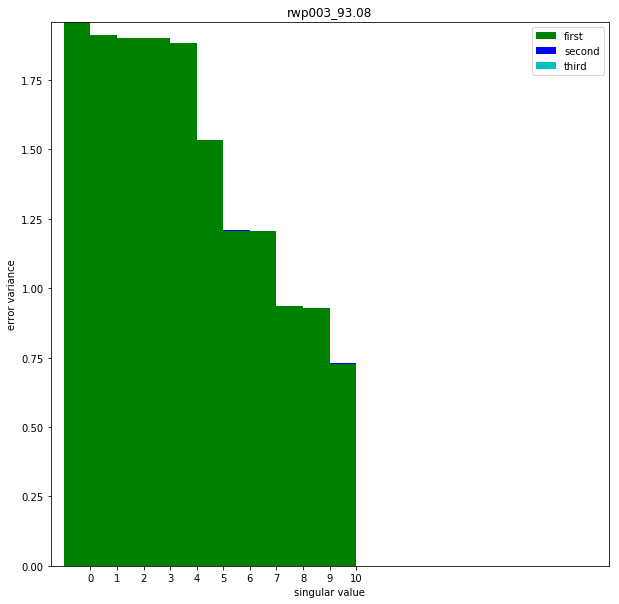

In [21]:
colors = {"first": 'g', "second": 'b', "third": 'c'}
max_idx = 19
idx = sing_vals[:max_idx]
for ipred, pred in enumerate(forecasts):
    pred = pred.lower()
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    ax.set_title(pred)
    first = errvar_df[("first", pred)][:max_idx]
    second = errvar_df[("second", pred)][:max_idx]
    third = errvar_df[("third", pred)][:max_idx]
    ax.bar(idx, first, width=1.0, edgecolor="none", 
           facecolor=colors["first"], label="first",bottom=0.0)
    ax.bar(idx, second, width=1.0, edgecolor="none", 
           facecolor=colors["second"], label="second", bottom=first)
    ax.bar(idx, third, width=1.0, edgecolor="none", 
           facecolor=colors["third"], label="third", 
           bottom=second+first)
    ax.set_xlim(-1,max_idx+1)
    ax.set_xticks(idx+0.5)
    ax.set_xticklabels(idx)
    #if ipred == 2:
    ax.set_xlabel("singular value")
    ax.set_ylabel("error variance")
    ax.legend(loc="upper right")
plt.show()

Here we see the trade off between getting a good fit to push down the null-space (1st) term and the penalty for overfitting (the rise of the solution space (2nd) term)).  The sum of the first two terms in the "appearent" error variance (e.g. the uncertainty that standard analyses would yield) without considering the contribution from the omitted parameters.  You can verify this by checking prior uncertainty from the Schur's complement notebook against the zero singular value result using only terms 1 and 2. Note that the top of the green bar is the limit of traditional uncertainty/error variance analysis: accounting for parameter and observation.

You can also see the added penalty for not adjusting the well flux and recharge parameters.

The rest of the cell contains analysis for the Freyberg model - need to do a similar analysis for MRGB or RSJ model:

For the water level at the end of the calibration period forecast (``or28c05_0``), the fact the we have left parameters out doesn't matter - the parameter compensation associated with fixing uncertain model inputs can be "calibrated out" beyond 2 singular values.  For the water level forecast during forecast period (``or28c05_1``), the penalty for fixed parameters persists -it s nearly constant over the range of singular values.  

For ``sw_gw_0``, the situation is much worse: not only are we greatly underestimating uncertainty by omitting parameters, worse, calibration increases the uncertainty for this forecast because the adjustable parametres are compensating for the omitted, uncertaint parameters in ways that are damanaging to the forecast. 

For the forecast period sw-gw exchange (``sw_gw_1``), calibration doesn't help or hurt - this forecast depend entirely on null space parameter components.  But treating the recharge and well pumpage as "fixed" (omitted) results in greatly underestimated uncertainty.     



Let's check the ```errvar``` results against the results from ```schur```. This is simple with ```pyemu```, we simply  cast the ```errvar``` type to a ```schur``` type:

In [23]:
schur = la.get(astype=pyemu.Schur)
schur_prior = schur.prior_forecast
schur_post = schur.posterior_forecast
print("{0:10s} {1:>12s} {2:>12s} {3:>12s} {4:>12s}"
      .format("forecast","errvar prior","errvar min",
              "schur prior", "schur post"))
for ipred, pred in enumerate(forecasts):
    first = errvar_df[("first", pred)][:max_idx]
    second = errvar_df[("second", pred)][:max_idx]  
    min_ev = np.min(first + second)
    prior_ev = first[0] + second[0]
    prior_sh = schur_prior[pred]
    post_sh = schur_post[pred]
    print("{0:12s} {1:12.6f} {2:12.6f} {3:12.6} {4:12.6f}"
          .format(pred,prior_ev,min_ev,prior_sh,post_sh))

forecast   errvar prior   errvar min  schur prior   schur post
rwp003_93.08     1.957639     0.730416      1.95764     0.050721


We see that the prior from ```schur``` class matches the two-term ```errvar``` result at zero singular values.  We also see, as expected, the posterior from ```schur``` is lower than the two-term ```errvar``` result.  This shows us that the "appearent" uncertainty in these predictions, as found through application of Bayes equation, is being under estimated because of the ill effects of the omitted parameters.